# DonorsChoose Funding Analysis 
### Wally Chang, Aditi Ramprasad, Jai Chandnan, Ye Tong
<br>
DonorsChoose is an innovative platform that connects donors with teachers from across the United States to fund school projects. These projects range from simple supplies for a science experiment to funds for field trips, providing resources that schools otherwise might not afford. In this project, you will analyze data from the DonorsChoose platform to identify patterns in funding, project success, and factors that influence donor contributions.



In [269]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## Import Data and Merge Files
Since our exploration is on maximizing funding amount and success percentage, we drop na values based on the column 'donation_to_project', which contains the main donation information.

In [270]:
# Load data
project = pd.read_csv("project.csv")
donation = pd.read_csv("donation.csv")
school = pd.read_csv("school.csv")
account = pd.read_csv("account.csv",dtype={5: str}) #requires data type specification for column 5

In [271]:
# Rename columns for consistency with other files
donation = donation.rename(columns={'donoracctid':'accountid'})
project = project.rename(columns={'teacheracctid':'accountid'})

In [272]:
# Merge files to a combined dataframe
tmp0 = project.merge(donation, on=['accountid', 'projectid'], how='outer')
tmp1 = tmp0.merge(school, on='schoolid', how='outer')
combined_df = tmp1.merge(account,on='accountid', how='outer')

In [273]:
# Remove NA values from the donation_to_project column (imperative column)
combined_df = combined_df.dropna(subset=['donation_to_project'])

In [274]:
# Sort by accountid
pd.set_option('display.max_columns', 500)
combined_df.sort_values('accountid')

# Show df
combined_df

,projectid,accountid,schoolid,primary_focus_subject,primary_focus_area,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,vendor_shipping_charges,sales_tax,payment_processing_charges,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,total_donations,num_donors,eligible_double_your_impact_match,eligible_almost_home_match,funding_status,date_posted,date_completed,date_thank_you_packet_mailed,date_expiration,donationid,donation_timestamp,donation_to_project,donation_optional_support,donation_total,donation_included_optional_support,payment_method,payment_included_acct_credit,payment_included_campaign_gift_card,payment_included_web_purchased_gift_card,payment_was_promo_matched,is_teacher_referred,givingpageid,giving_page_type,for_honoree,thank_you_packet_mailed,ncesid,latitude,longitude,city_x,state_x,zip,metro,district,county,charter,magnet,year_round,nlns,kipp,charter_ready_promise,city_y,state_y,zip3,is_teacher,teacher_prefix,teacher_teach_for_america,teacher_ny_teaching_fellow
68,147974.0,14659,2.0,Literacy,Literacy & Language,Literature & Writing,Literacy & Language,Books,highest poverty,Grades 9-12,32.14,0.0,4.82,9.0,367.35,447.99,200.0,447.99,3.0,1.0,0.0,completed,2009-08-12 00:00:00,2009-09-08 00:00:00,2009-12-04 00:00:00,2010-01-13 00:00:00,4905337.0,2009-08-21 09:06:42,20.50,4.50,25.0,1.0,creditcard,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,3.600077e+11,40.765517,-73.96009,New York City,NY,10065.0,NaN,New York City Dept Of Ed,New York (Manhattan),0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1.0,Ms.,0.0,0.0
74,212598.0,14659,2.0,Literacy,Literacy & Language,Literature & Writing,Literacy & Language,Other,highest poverty,Grades 9-12,22.56,0.0,3.38,35.0,286.54,329.36,200.0,325.62,6.0,0.0,1.0,completed,2010-07-23 00:00:00,2010-09-08 00:00:00,2011-01-18 00:00:00,2010-12-23 00:00:00,3409988.0,2010-09-02 22:15:55,43.50,6.50,50.0,1.0,creditcard,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,3.600077e+11,40.765517,-73.96009,New York City,NY,10065.0,NaN,New York City Dept Of Ed,New York (Manhattan),0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1.0,Ms.,0.0,0.0
90,802020.0,14659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,556299.0,2015-02-13 14:58:54,42.50,7.50,50.0,1.0,no_cash_received,0.0,0.0,1.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Ms.,0.0,0.0
91,778850.0,14659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,935423.0,2014-12-02 17:51:10,8.50,1.50,10.0,1.0,paypal,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Ms.,0.0,0.0
105,110794.0,34241,3.0,Literacy,Literacy & Language,Special Needs,Special Needs,Technology,moderate poverty,Grades PreK-2,23.32,0.0,5.83,17.0,279.00,340.24,25.0,348.75,2.0,0.0,0.0,completed,2008-11-22 00:00:00,2009-04-21 00:00:00,2009-04-24 00:00:00,2009-04-23 00:00:00,2725696.0,2008-12-12 20:17:57,20.00,5.00,25.0,1.0,no_cash_received,0.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,3.600077e+11,40.770233,-73.95076,New York City,NY,10075.0,NaN,New York City Dept Of Ed,New York (Manhattan),0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1.0,Ms.,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7179429,70405.0,2855583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6211919.0,2008-03-31 14:12:13,85.00,15.00,100.0,1.0,no_cash_received,0.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,West Hollywood,CA,900.0,0.0,NaN,NaN,NaN
7179430,1084050.0,2855584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62

## Basic Data Examination

##### % Teachers in the dataframe as opposed to donors

In [275]:
sum(combined_df['is_teacher'])/len(combined_df)

0.14846402646766976

##### Number of Cities and Schools per City

In [276]:
combined_df_filtered_by_city = combined_df.dropna(subset="city_x")
city_school_counts = combined_df_filtered_by_city['city_x'].value_counts()
city_school_counts

city_x
New York City    30097
Los Angeles      12684
Chicago          12640
Philadelphia      6533
Indianapolis      5370
                 ...  
Unalakleet           1
Parmelee             1
Cankton              1
Halliday             1
Shasta Lake          1
Name: count, Length: 7254, dtype: int64

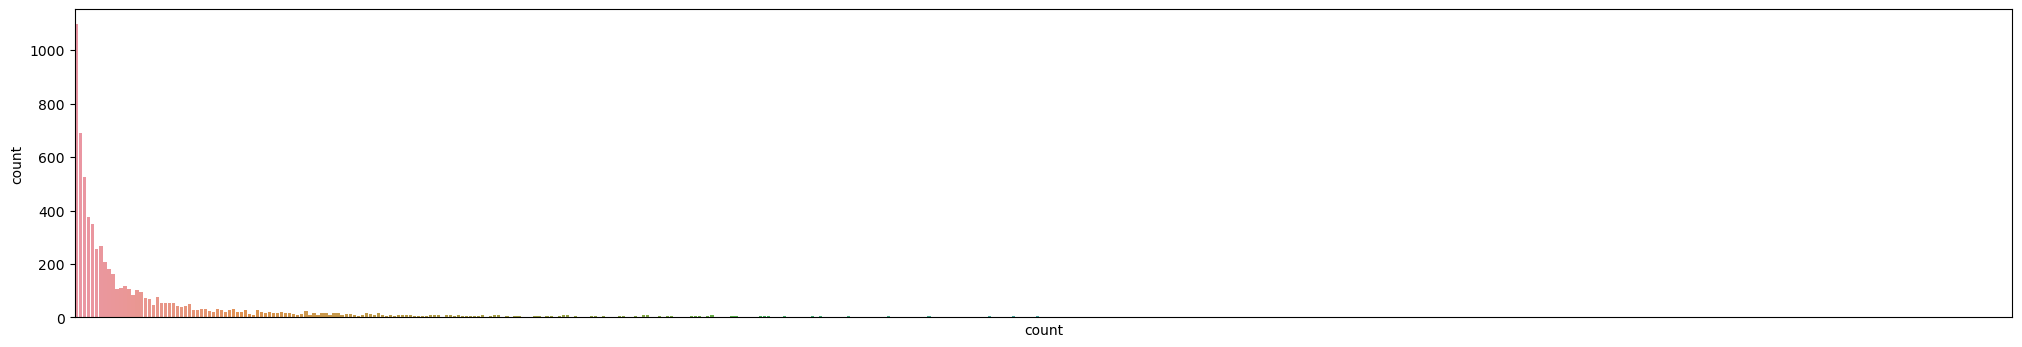

In [277]:
plt.figure(figsize=(25, 4))
sns.countplot(x=city_school_counts)
plt.xticks([])
plt.show()  # There is a long tail

##### percentage of successful funding completions for each poverty level

In [278]:
metro_success_percentages = combined_df.groupby('metro')['funding_status'] \
    .apply(lambda x: (x == 'completed').mean() * 100) \
    .reset_index(name='success_percentage')

metro_success_percentages

,metro,success_percentage
0,rural,85.231511
1,suburban,86.278050
2,urban,88.148865


In [279]:
poverty_success_percentages = combined_df.groupby('poverty_level')['funding_status'] \
    .apply(lambda x: (x == 'completed').mean() * 100) \
    .reset_index(name='success_percentage')

poverty_success_percentages

,poverty_level,success_percentage
0,high poverty,86.719913
1,highest poverty,87.028032
2,low poverty,84.630739
3,moderate poverty,87.204154


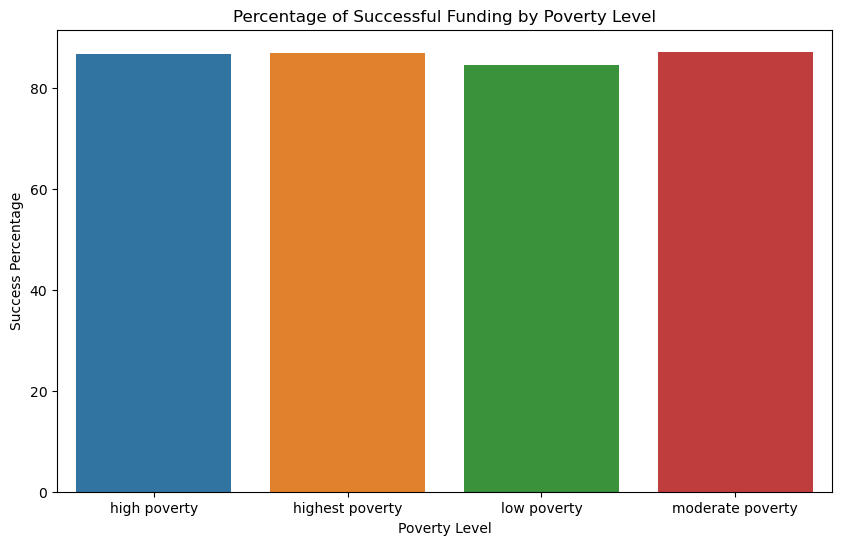

In [280]:
plt.figure(figsize=(10, 6))
sns.barplot(data=poverty_success_percentages, x='poverty_level', y='success_percentage')
plt.title('Percentage of Successful Funding by Poverty Level')
plt.xlabel('Poverty Level')
plt.ylabel('Success Percentage')
plt.show()

##### Success by resource type

In [281]:
resource_success_percentages = combined_df.groupby('resource_type')['funding_status'] \
    .apply(lambda x: (x == 'completed').mean() * 100) \
    .reset_index(name='success_percentage')

resource_success_percentages

,resource_type,success_percentage
0,Books,90.358356
1,Other,89.904439
2,Supplies,87.252974
3,Technology,84.123224
4,Trips,88.834873
5,Visitors,86.960784


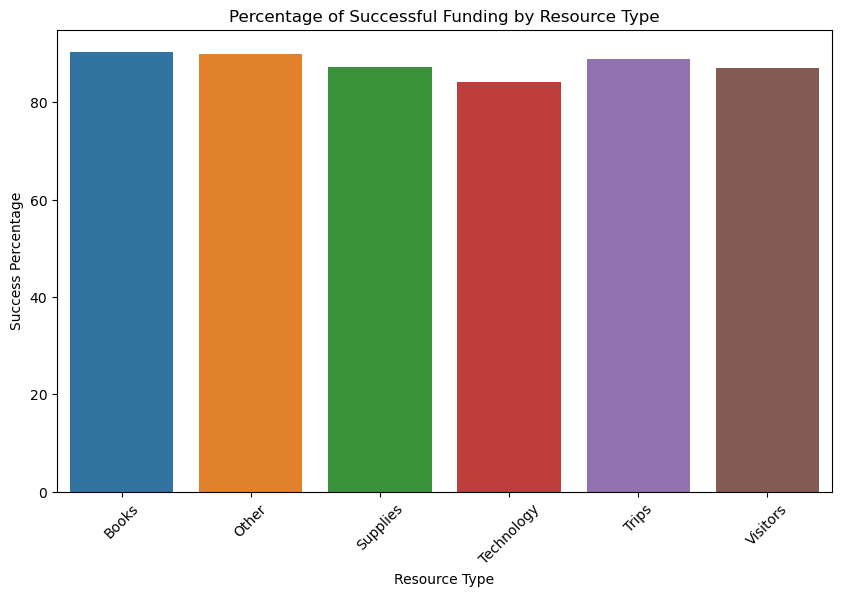

In [282]:
plt.figure(figsize=(10, 6))
sns.barplot(data=resource_success_percentages, x='resource_type', y='success_percentage')
plt.title('Percentage of Successful Funding by Resource Type')
plt.xlabel('Resource Type')
plt.ylabel('Success Percentage')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

##### Analysis by Metro Type (urban, suburban, rural)

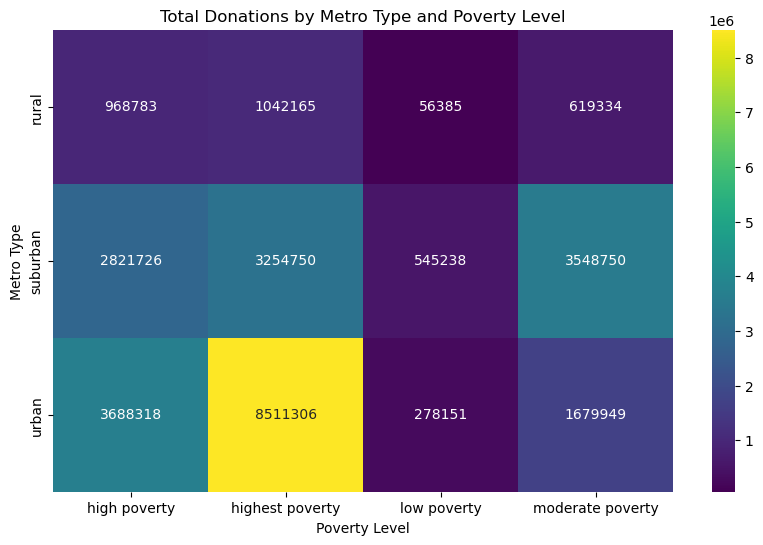

In [283]:
# Code adjusted based on suggestions from ChatGPT, OpenAI, 2023
total_donations_per_group = combined_df.groupby(['metro', 'poverty_level'])['donation_to_project'].sum().reset_index()

pivot_table = total_donations_per_group.pivot(index='metro', columns='poverty_level', values='donation_to_project')

# heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data=pivot_table, annot=True, cmap='viridis', fmt='.0f')
plt.title('Total Donations by Metro Type and Poverty Level')
plt.xlabel('Poverty Level')
plt.ylabel('Metro Type')
plt.show()

/var/folders/qy/mhlfbdm940n8kbpppfc_whdh0000gn/T/ipykernel_6210/1883305357.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=total_donations_per_group, x='metro', y='donation_to_project', hue='poverty_level', ci=None)


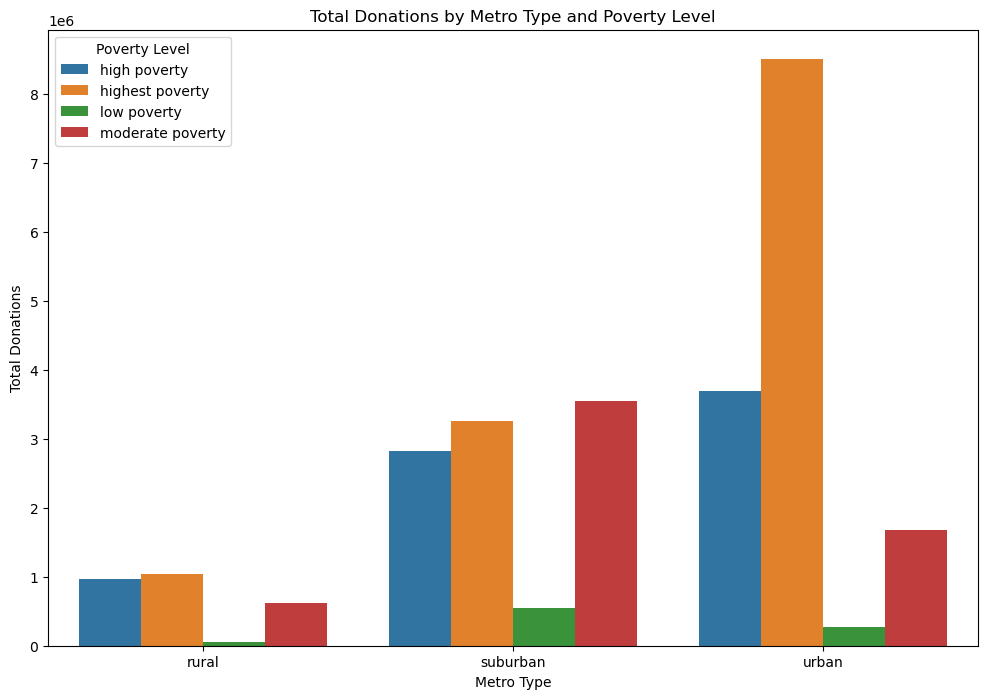

In [284]:
plt.figure(figsize=(12, 8))
sns.barplot(data=total_donations_per_group, x='metro', y='donation_to_project', hue='poverty_level', ci=None)
plt.title('Total Donations by Metro Type and Poverty Level')
plt.xlabel('Metro Type')
plt.ylabel('Total Donations')
plt.legend(title='Poverty Level')
plt.show()

## Examine effect of being a NY Teaching Fellow or being associated with Teach for America on donation amounts

##### NY Teaching Fellow Examination

In [285]:
# Remove NA values from teachng fellow column
teaching_fellow_na_removed = combined_df.dropna(subset=['teacher_ny_teaching_fellow'])

# Filter by unique results (whether or not teacher is NY fellow)
unique_teaching_fellow = teaching_fellow_na_removed['teacher_ny_teaching_fellow'].unique()

# Create filtered datasets containing only data if the teacher is a teaching fellow or not
for i in unique_teaching_fellow:
    if i == 0:
        is_not_ny_teaching_fellow = teaching_fellow_na_removed[teaching_fellow_na_removed['teacher_ny_teaching_fellow']==i]
    if i == 1:
        is_ny_teaching_fellow = teaching_fellow_na_removed[teaching_fellow_na_removed['teacher_ny_teaching_fellow']==i]

In [286]:
# See summary stats
print("NOT a NY Teaching Fellow")
print(is_not_ny_teaching_fellow["donation_to_project"].describe())

print("\nIS a NY Teaching Fellow")
print(is_ny_teaching_fellow["donation_to_project"].describe())

NOT a NY Teaching Fellow
count    873348.000000
mean         40.322972
std         235.561233
min           0.000000
25%           1.700000
50%          10.000000
75%          28.900000
max       21299.950000
Name: donation_to_project, dtype: float64

IS a NY Teaching Fellow
count    8179.000000
mean       57.010252
std       148.054790
min         0.020000
25%         8.500000
50%        24.540000
75%        75.000000
max      8500.000000
Name: donation_to_project, dtype: float64


In [287]:
# Visualize barplot of donation distribution
sns.barplot(teaching_fellow_na_removed, x='teacher_ny_teaching_fellow', y='donation_to_project', )
plt.title('Effect of Being a NY Teaching Fellow on Mean Donation Amount')
plt.show()

<Axes: title={'center': 'IS a NY Teaching Fellow, Proportion of Fundng Statuses'}, xlabel='funding_status', ylabel='Proportion'>

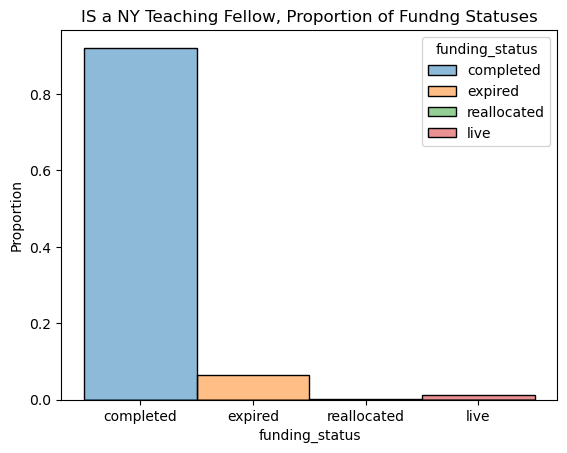

In [ ]:
# Visualize funding status proportion based on being a NY Teaching Fellow
plt.title('IS a NY Teaching Fellow, Proportion of Fundng Statuses')
sns.histplot(combined_df[combined_df['teacher_ny_teaching_fellow']==1], x='funding_status', hue='funding_status', stat='proportion')

<Axes: title={'center': 'NOT a NY Teaching Fellow, Proportion of Fundng Statuses'}, xlabel='funding_status', ylabel='Proportion'>

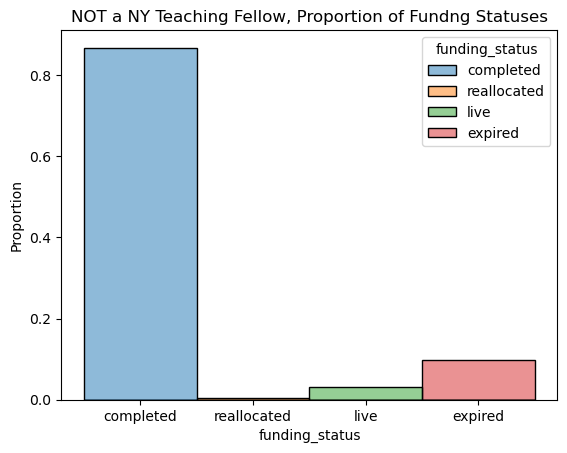

In [ ]:
# Visualize funding status proportion based on being a NY Teaching Fellow
plt.title('NOT a NY Teaching Fellow, Proportion of Fundng Statuses')
sns.histplot(combined_df[combined_df['teacher_ny_teaching_fellow']==0], x='funding_status', hue='funding_status', stat='proportion')

##### Teach for America Examination

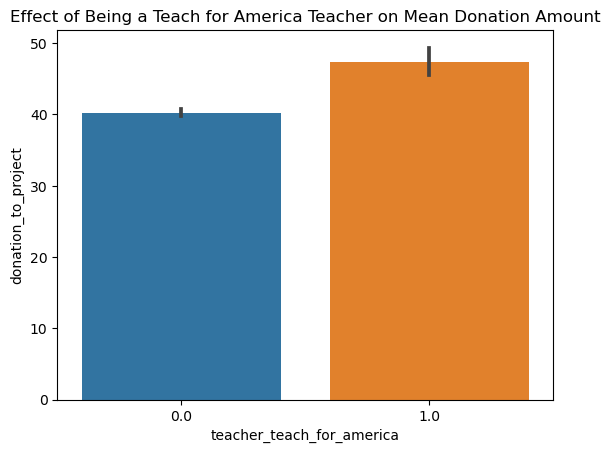

In [ ]:
sns.barplot(combined_df, x='teacher_teach_for_america', y='donation_to_project', )
plt.title('Effect of Being a Teach for America Teacher on Mean Donation Amount')
plt.show()

<Axes: title={'center': 'IS a Teach for America Teacher, Proportion of Fundng Statuses'}, xlabel='funding_status', ylabel='Proportion'>

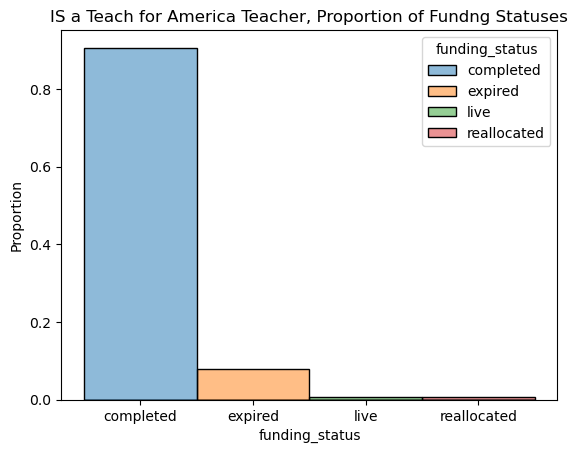

In [ ]:
# Visualize funding status proportion based on being a Teach for America Teacher
plt.title('IS a Teach for America Teacher, Proportion of Fundng Statuses')
sns.histplot(combined_df[combined_df['teacher_teach_for_america']==1], x='funding_status', hue='funding_status', stat='proportion')

<Axes: title={'center': 'NOT a Teach for America Teacher, Proportion of Fundng Statuses'}, xlabel='funding_status', ylabel='Proportion'>

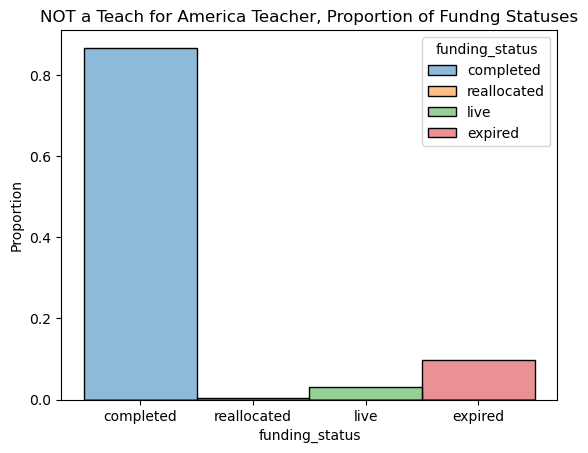

In [ ]:
# Visualize funding status proportion based on being a Teach for America Teacher
plt.title('NOT a Teach for America Teacher, Proportion of Fundng Statuses')
sns.histplot(combined_df[combined_df['teacher_teach_for_america']==0], x='funding_status', hue='funding_status', stat='proportion')

## Examine Impact of Price Tag on a Project (total_price_excluding_optional_support) on Project Funding Completion Status

<Axes: xlabel='total_price_excluding_optional_support', ylabel='Density'>

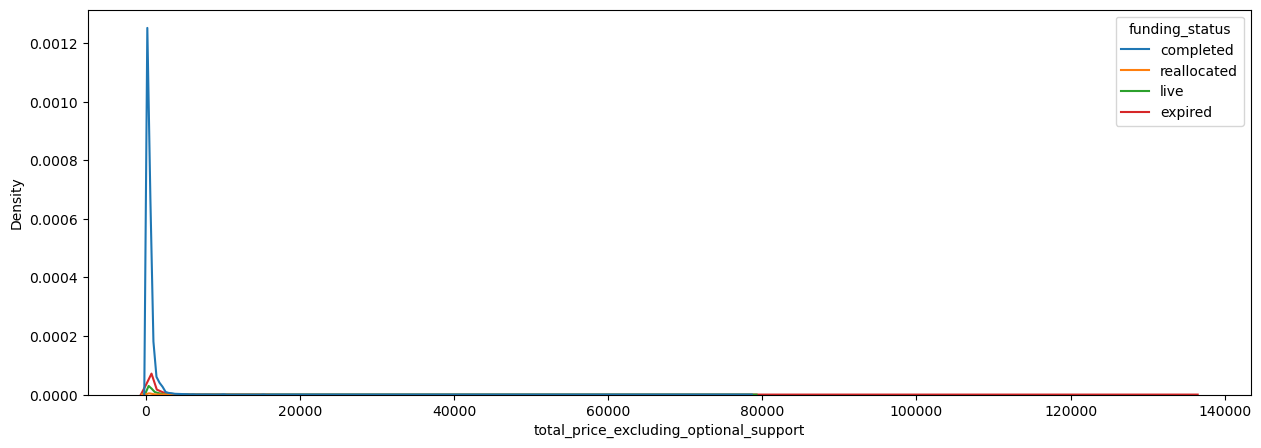

In [ ]:
plt.figure(figsize=(15,5))
sns.kdeplot(data=combined_df, x='total_price_excluding_optional_support', hue='funding_status')

/Users/wally/anaconda3/envs/amex/lib/python3.11/site-packages/matplotlib/scale.py:616: RuntimeWarning: overflow encountered in power
  return 1.0 / (1 + 10**(-a))


<Axes: xlabel='total_price_excluding_optional_support', ylabel='Density'>

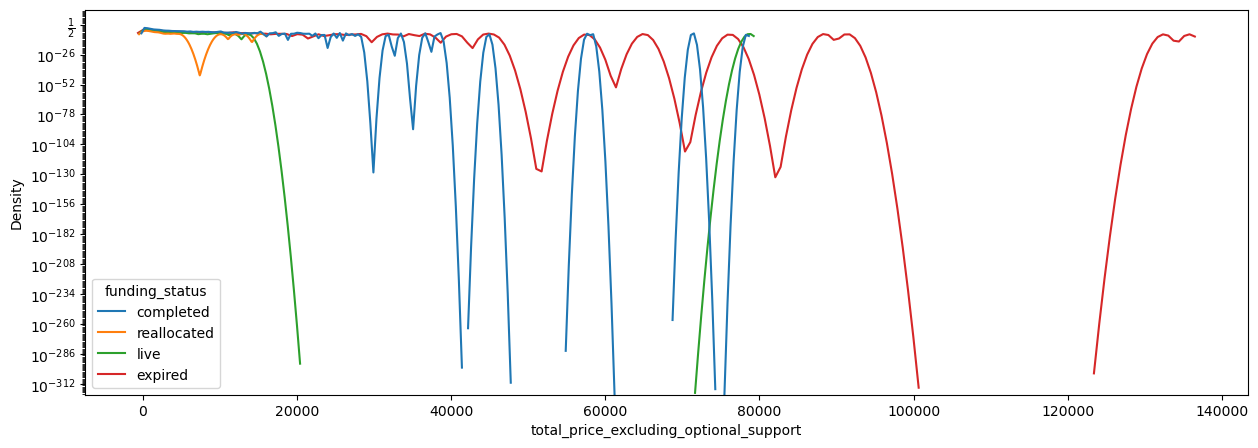

In [ ]:
# Using logit scale
plt.figure(figsize=(15,5))
plt.yscale('logit')
sns.kdeplot(data=combined_df, x='total_price_excluding_optional_support', hue='funding_status')

## Visualize Poverty Level and Focus Areas Distribution and Correlation with Fund Raising Success

/var/folders/qy/mhlfbdm940n8kbpppfc_whdh0000gn/T/ipykernel_6210/2127007643.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


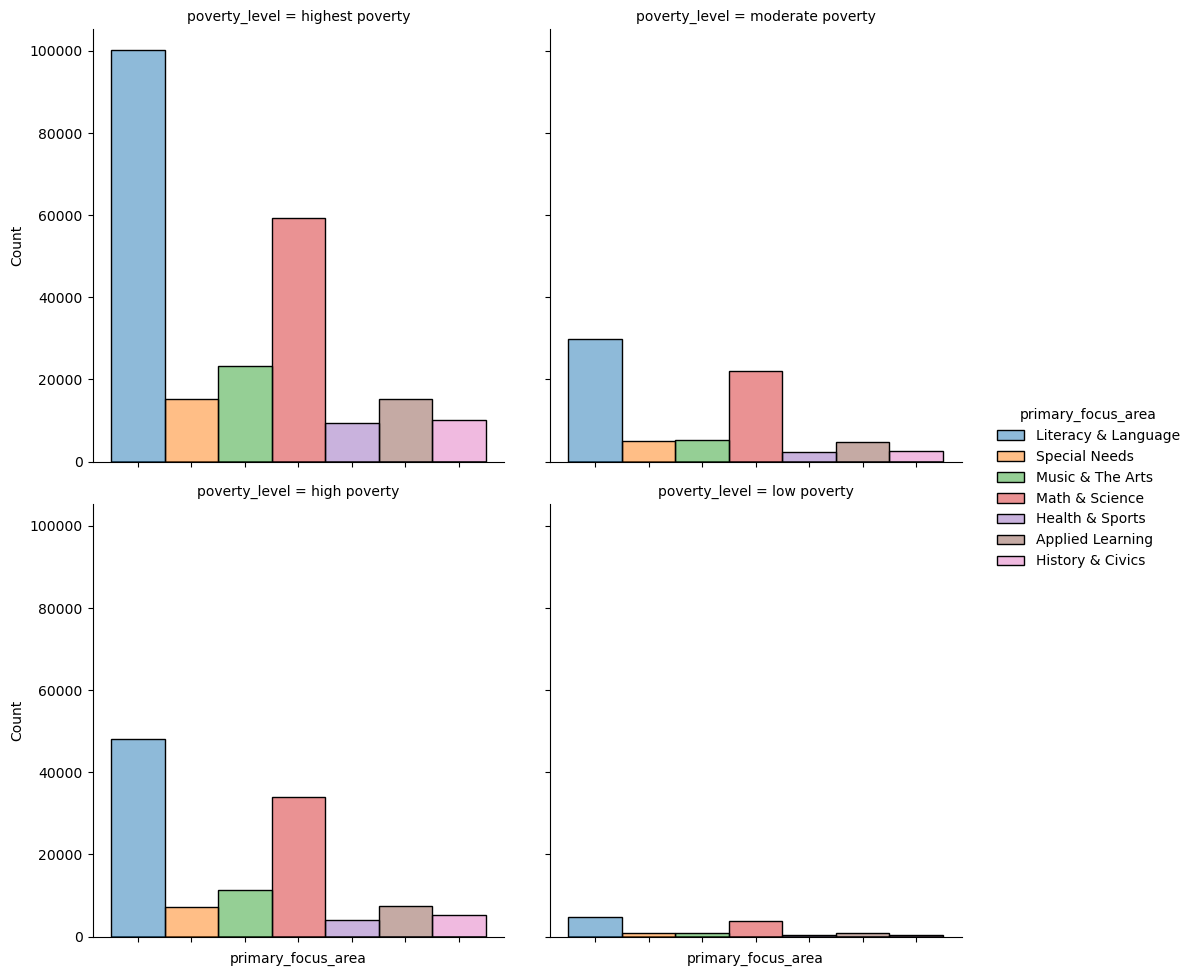

In [ ]:
g = sns.displot(data=combined_df, x='primary_focus_area', col='poverty_level', hue='primary_focus_area', col_wrap=2)
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.show()

In [ ]:
# Calculate percentage of successful funding completions for each category
success_percentages = combined_df.groupby(['primary_focus_area', 'poverty_level'])['funding_status'] \
    .apply(lambda x: (x == 'completed').mean() * 100) \
    .reset_index(name='success_percentage')

# Add a column with the count of each focus area within each poverty level
success_percentages['total count'] = combined_df.groupby(['primary_focus_area', 'poverty_level']).size().reset_index(name='count')['count']

success_percentages = success_percentages.sort_values('success_percentage', ascending=False)

success_percentages

,primary_focus_area,poverty_level,success_percentage,total count
8,History & Civics,high poverty,89.069811,5343
3,Applied Learning,moderate poverty,88.825032,4698
2,Applied Learning,low poverty,88.726790,754
9,History & Civics,highest poverty,88.496902,10006
21,Music & The Arts,highest poverty,88.189755,23251
11,History & Civics,moderate poverty,87.739752,2659
1,Applied Learning,highest poverty,87.640596,15292
13,Literacy & Language,highest poverty,87.473565,100244
15,Literacy & Language,moderate poverty,87.458525,29837
20,Music & The Arts,high poverty,87.231441,11450


_________________________________

## Aditi Code - Analysis of KIPP and NLNS on Funding

In [ ]:
kipp_schools = school[school['kipp'] == 1]
nlns_schools = school[school['nlns'] == 1]

# Merge with project data
kipp_project_data = pd.merge(project, kipp_schools, on='schoolid', how='inner')
nlns_project_data = pd.merge(project, nlns_schools, on='schoolid', how='inner')

kipp_project_data.head()
non_kipp_project_data = project[~project['schoolid'].isin(kipp_project_data['schoolid'])]

In [ ]:
project['total_donations'].describe()

count    1.203287e+06
mean     4.163221e+02
std      8.031547e+02
min      0.000000e+00
25%      6.000000e+01
50%      3.018000e+02
75%      5.378500e+02
max      2.492533e+05
Name: total_donations, dtype: float64

In [ ]:
kipp_donation_stats = kipp_project_data['total_donations'].describe()
kipp_donation_stats


count     6192.000000
mean       565.025746
std       1018.674411
min          0.000000
25%        213.220000
50%        442.910000
75%        697.622500
max      40017.000000
Name: total_donations, dtype: float64

In [ ]:
non_kipp_donation_stats = non_kipp_project_data['total_donations'].describe()
non_kipp_donation_stats

count    1.197095e+06
mean     4.155529e+02
std      8.018182e+02
min      0.000000e+00
25%      6.000000e+01
50%      3.010000e+02
75%      5.371200e+02
max      2.492533e+05
Name: total_donations, dtype: float64

In [ ]:
# Analyze funding success rates
kipp_funding_success_rate = kipp_project_data['funding_status'].value_counts(normalize=True) * 100
kipp_funding_success_rate

funding_status
completed      76.711886
expired        19.331395
live            2.374031
reallocated     1.582687
Name: proportion, dtype: float64

In [ ]:
non_kipp_funding_success_rate = non_kipp_project_data['funding_status'].value_counts(normalize=True) * 100
non_kipp_funding_success_rate

funding_status
completed      66.186978
expired        27.769976
live            5.292228
reallocated     0.750818
Name: proportion, dtype: float64

In [ ]:
# Investigate distribution of resource types and focus areas
kipp_resource_type_distribution = kipp_project_data['resource_type'].value_counts(normalize=True) * 100
kipp_resource_type_distribution

resource_type
Supplies      32.170543
Books         30.894703
Technology    27.196382
Other          8.010336
Trips          1.679587
Visitors       0.048450
Name: proportion, dtype: float64

In [ ]:
non_kipp_resource_type_distribution = non_kipp_project_data['resource_type'].value_counts(normalize=True) * 100
non_kipp_resource_type_distribution

resource_type
Supplies      37.068593
Technology    32.864316
Books         18.516377
Other         10.173987
Trips          1.176315
Visitors       0.200411
Name: proportion, dtype: float64

In [ ]:
kipp_focus_area_distribution = kipp_project_data['primary_focus_area'].value_counts(normalize=True) * 100
kipp_focus_area_distribution

primary_focus_area
Literacy & Language    44.299096
Math & Science         27.923127
Music & The Arts        8.397933
History & Civics        5.846253
Applied Learning        5.717054
Special Needs           4.085917
Health & Sports         3.730620
Name: proportion, dtype: float64

In [ ]:
non_kipp_focus_area_distribution = non_kipp_project_data['primary_focus_area'].value_counts(normalize=True) * 100
non_kipp_focus_area_distribution

primary_focus_area
Literacy & Language    42.215565
Math & Science         27.116183
Music & The Arts        8.762381
Applied Learning        6.679593
Special Needs           6.568737
Health & Sports         4.451614
History & Civics        4.205926
Name: proportion, dtype: float64

In [ ]:
kipp_count = (combined_df['kipp'] == 1).sum()

# Count the number of schools that are NLNS-affiliated
nlns_count = (combined_df['nlns'] == 1).sum()

print("Number of schools affiliated with KIPP:", kipp_count)
print("Number of schools affiliated with NLNS:", nlns_count)

Number of schools affiliated with KIPP: 1751
Number of schools affiliated with NLNS: 4123


In [ ]:
non_kipp_count = (combined_df['kipp'] == 0).sum()
print("Number of schools not affiliated with KIPP:", non_kipp_count)

non_nlns_count = (combined_df['nlns'] == 0).sum()
print("Number of schools not affiliated with nlns:", non_nlns_count)

Number of schools not affiliated with KIPP: 432470
Number of schools not affiliated with nlns: 430098


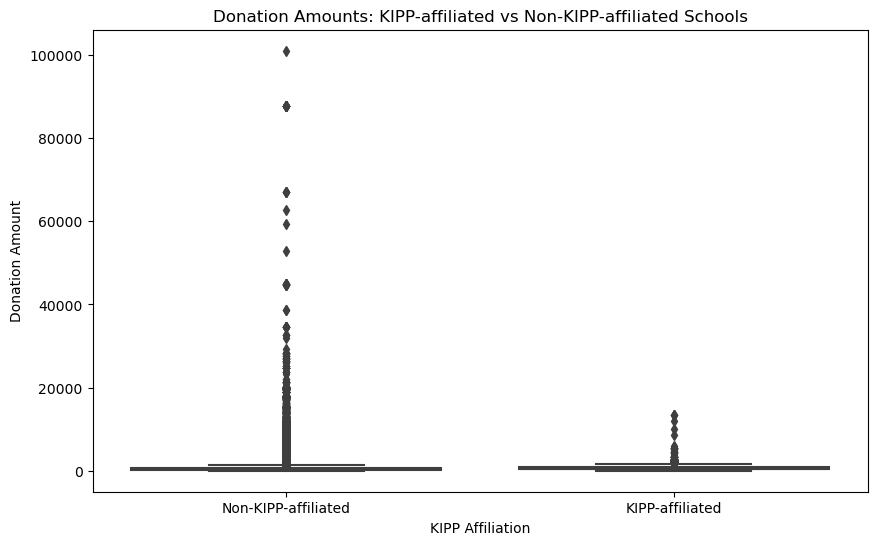

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='kipp', y='total_donations', data=combined_df)
plt.title('Donation Amounts: KIPP-affiliated vs Non-KIPP-affiliated Schools')
plt.xlabel('KIPP Affiliation')
plt.ylabel('Donation Amount')
plt.xticks([0, 1], ['Non-KIPP-affiliated', 'KIPP-affiliated'])
plt.show()

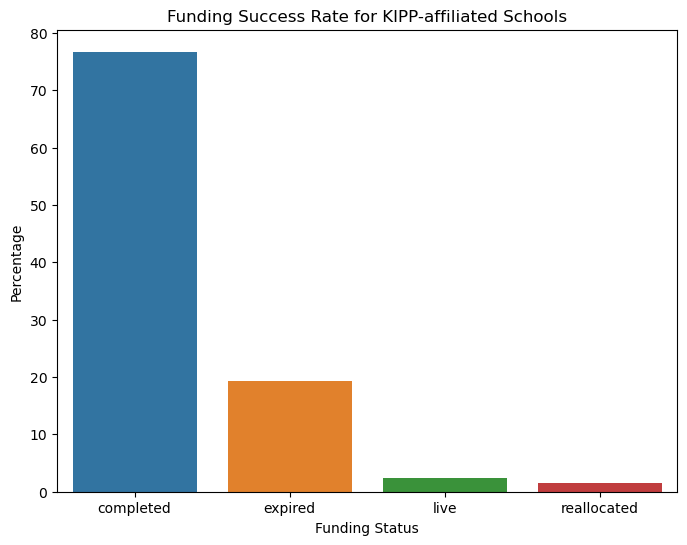

In [ ]:
# Code adjusted based on suggestions from ChatGPT, OpenAI, 2023
plt.figure(figsize=(8, 6))
sns.barplot(x=kipp_funding_success_rate.index, y=kipp_funding_success_rate.values)
plt.title('Funding Success Rate for KIPP-affiliated Schools')
plt.xlabel('Funding Status')
plt.ylabel('Percentage')
plt.savefig(f"Funding Success Rate for kipp affiliation.png")
plt.show()

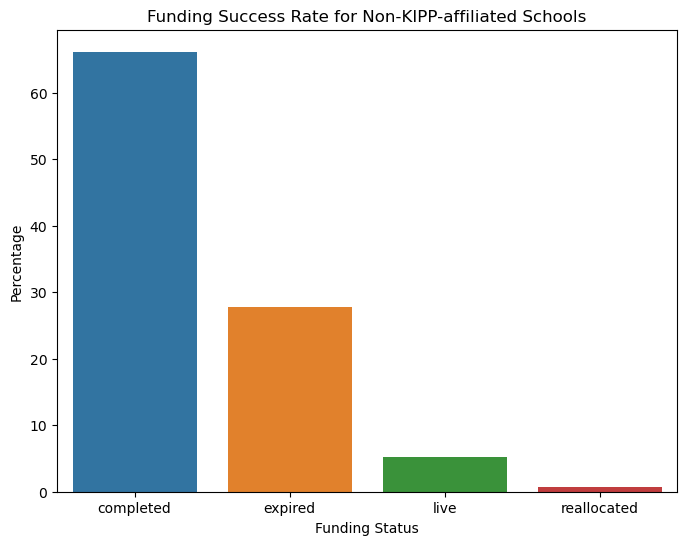

In [ ]:
# Code adjusted based on suggestions from ChatGPT, OpenAI, 2023
plt.figure(figsize=(8, 6))
sns.barplot(x=non_kipp_funding_success_rate.index, y=non_kipp_funding_success_rate.values)
plt.title('Funding Success Rate for Non-KIPP-affiliated Schools')
plt.xlabel('Funding Status')
plt.ylabel('Percentage')
plt.savefig(f"Funding Success Rate for non kipp affiliation.png")
plt.show()

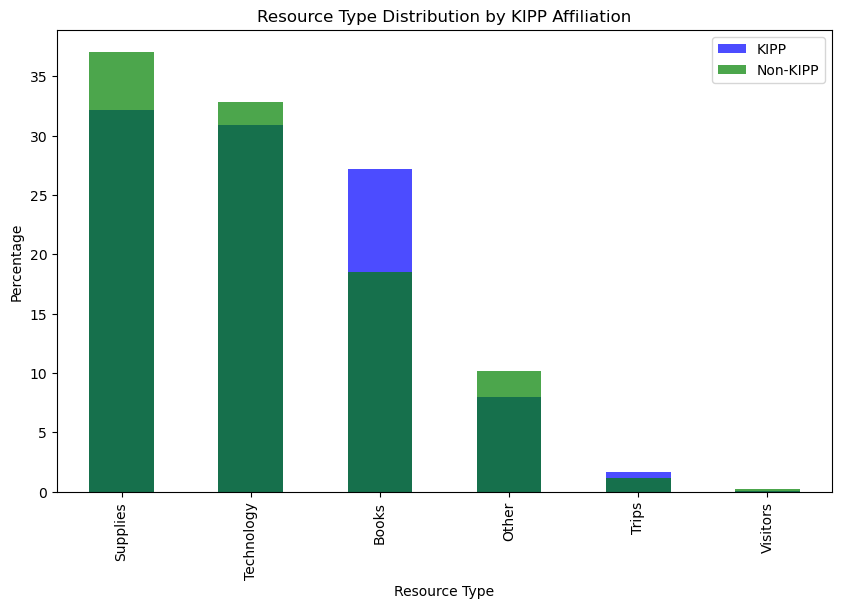

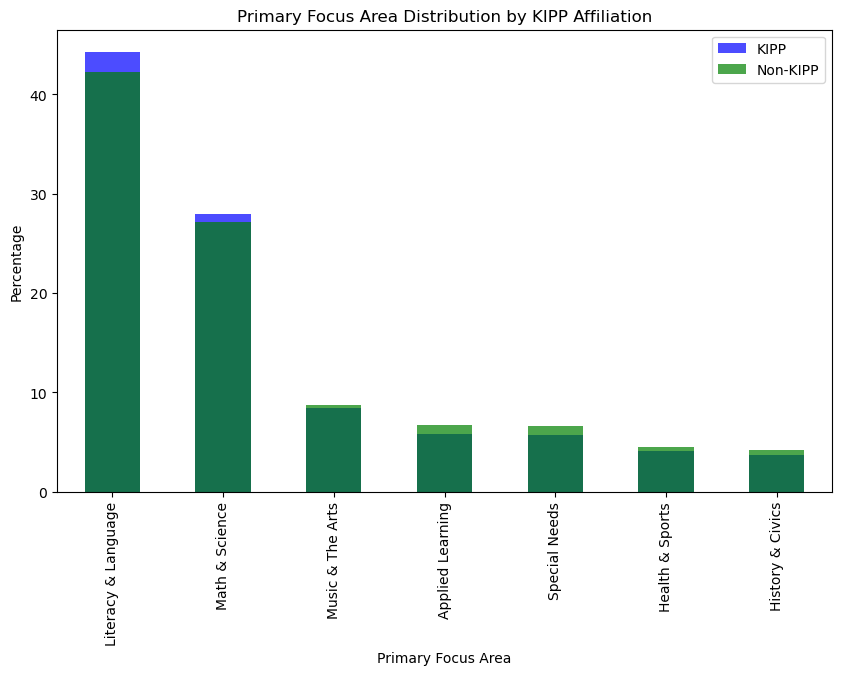

In [ ]:
# Code adjusted based on suggestions from ChatGPT, OpenAI, 2023
plt.figure(figsize=(10, 6))
kipp_resource_type_distribution.plot(kind='bar', color='blue', alpha=0.7, label='KIPP')
non_kipp_resource_type_distribution.plot(kind='bar', color='green', alpha=0.7, label='Non-KIPP')
plt.title('Resource Type Distribution by KIPP Affiliation')
plt.xlabel('Resource Type')
plt.ylabel('Percentage')
plt.legend()
plt.savefig(f"Resource Type Distribution by kipp affiliation.png")
plt.show()

# Focus area distribution
plt.figure(figsize=(10, 6))
kipp_focus_area_distribution.plot(kind='bar', color='blue', alpha=0.7, label='KIPP')
non_kipp_focus_area_distribution.plot(kind='bar', color='green', alpha=0.7, label='Non-KIPP')
plt.title('Primary Focus Area Distribution by KIPP Affiliation')
plt.xlabel('Primary Focus Area')
plt.ylabel('Percentage')
plt.legend()
plt.savefig(f"Primary Focus Area Distribution by kipp affiliation.png")
plt.show()

In [ ]:
nlns_donation_stats = nlns_project_data['total_donations'].describe()
nlns_donation_stats

count     13513.000000
mean        503.883577
std        1120.915383
min           0.000000
25%         179.460000
50%         386.320000
75%         592.610000
max      100800.010000
Name: total_donations, dtype: float64

In [ ]:
non_nlns_project_data = project[~project['schoolid'].isin(nlns_project_data['schoolid'])]
non_nlns_donation_stats = non_nlns_project_data['total_donations'].describe()
non_nlns_donation_stats


count    1.189774e+06
mean     4.153276e+02
std      7.987656e+02
min      0.000000e+00
25%      6.000000e+01
50%      3.007200e+02
75%      5.371800e+02
max      2.492533e+05
Name: total_donations, dtype: float64

In [ ]:
nlns_funding_success_rate = nlns_project_data['funding_status'].value_counts(normalize=True) * 100
nlns_funding_success_rate

funding_status
completed      76.393103
expired        19.270332
live            3.004514
reallocated     1.332051
Name: proportion, dtype: float64

In [ ]:
# Analyze funding success rates
non_nlns_funding_success_rate = non_nlns_project_data['funding_status'].value_counts(normalize=True) * 100
non_nlns_funding_success_rate

funding_status
completed      66.125836
expired        27.822595
live            5.303024
reallocated     0.748546
Name: proportion, dtype: float64

In [ ]:
nlns_resource_type_distribution = nlns_project_data['resource_type'].value_counts(normalize=True) * 100
nlns_resource_type_distribution

resource_type
Supplies      36.345471
Technology    28.478390
Books         24.740971
Other          8.000296
Trips          2.072232
Visitors       0.362641
Name: proportion, dtype: float64

In [ ]:

non_nlns_resource_type_distribution = non_nlns_project_data['resource_type'].value_counts(normalize=True) * 100
non_nlns_resource_type_distribution

resource_type
Supplies      37.051314
Technology    32.884629
Books         18.510107
Other         10.187413
Trips          1.168759
Visitors       0.197777
Name: proportion, dtype: float64

In [ ]:
nlns_focus_area_distribution = nlns_project_data['primary_focus_area'].value_counts(normalize=True) * 100
nlns_focus_area_distribution

primary_focus_area
Literacy & Language    44.542293
Math & Science         24.724340
Music & The Arts        9.250352
Applied Learning        7.585288
History & Civics        5.557611
Special Needs           5.328202
Health & Sports         3.011914
Name: proportion, dtype: float64

In [ ]:
non_nlns_focus_area_distribution = non_nlns_project_data['primary_focus_area'].value_counts(normalize=True) * 100
non_nlns_focus_area_distribution

primary_focus_area
Literacy & Language    42.199982
Math & Science         27.147550
Music & The Arts        8.754942
Applied Learning        6.664296
Special Needs           6.569905
Health & Sports         4.464214
History & Civics        4.199111
Name: proportion, dtype: float64

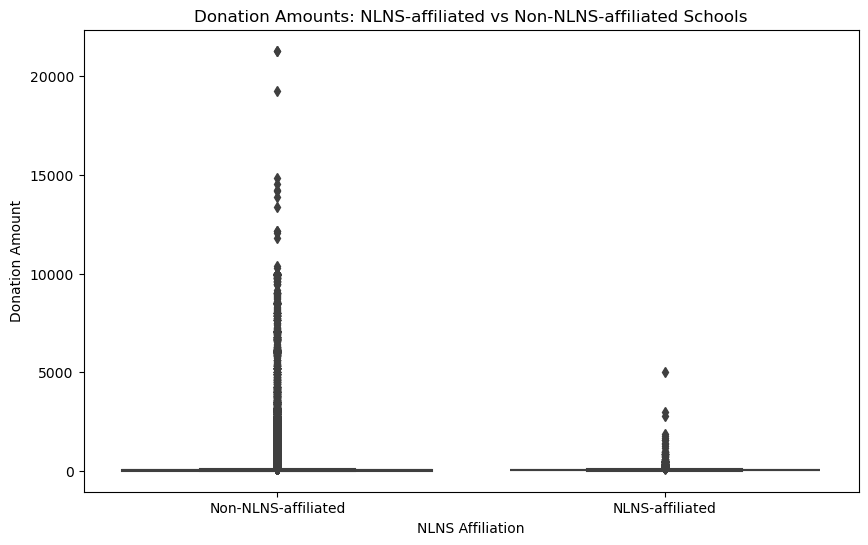

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='nlns', y='donation_to_project', data=combined_df)
plt.title('Donation Amounts: NLNS-affiliated vs Non-NLNS-affiliated Schools')
plt.xlabel('NLNS Affiliation')
plt.ylabel('Donation Amount')
plt.xticks([0, 1], ['Non-NLNS-affiliated', 'NLNS-affiliated'])
plt.show()

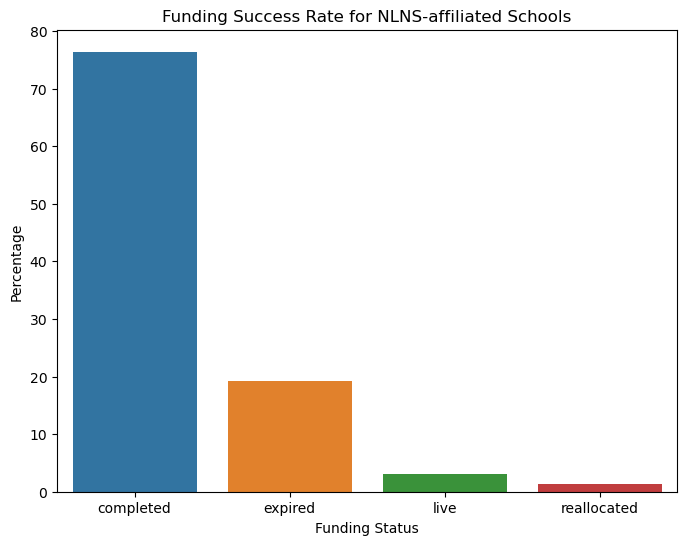

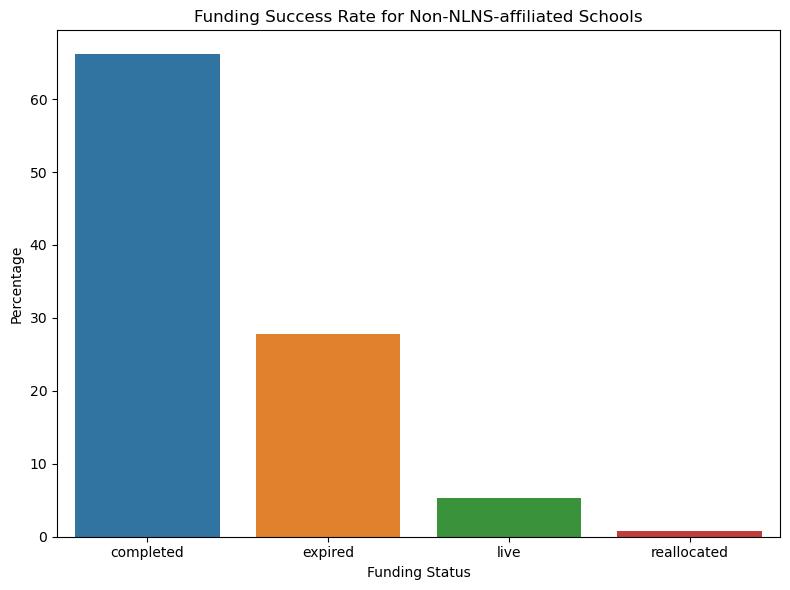

In [ ]:
# Code adjusted based on suggestions from ChatGPT, OpenAI, 2023
# Funding success rates
plt.figure(figsize=(8, 6))
sns.barplot(x=nlns_funding_success_rate.index, y=nlns_funding_success_rate.values)
plt.title('Funding Success Rate for NLNS-affiliated Schools')
plt.xlabel('Funding Status')
plt.ylabel('Percentage')
plt.savefig(f"Funding success rate nlns.png")

plt.figure(figsize=(8, 6))
sns.barplot(x=non_nlns_funding_success_rate.index, y=non_nlns_funding_success_rate.values)
plt.title('Funding Success Rate for Non-NLNS-affiliated Schools')
plt.xlabel('Funding Status')
plt.ylabel('Percentage')
plt.savefig(f"Funding success rate non nlns.png")

plt.tight_layout()
plt.show()

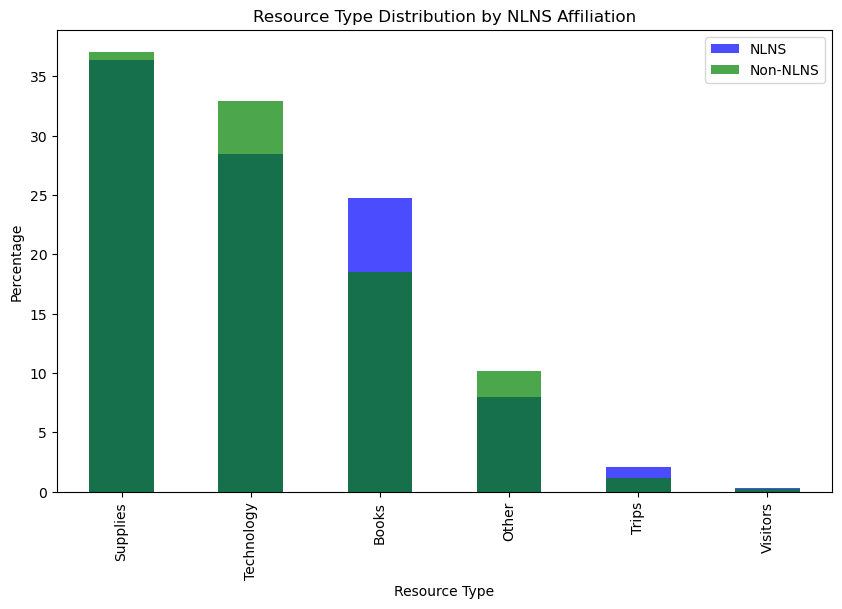

In [ ]:
# Code adjusted based on suggestions from ChatGPT, OpenAI, 2023
# Resource type distribution
plt.figure(figsize=(10, 6))
nlns_resource_type_distribution.plot(kind='bar', color='blue', alpha=0.7, label='NLNS')
non_nlns_resource_type_distribution.plot(kind='bar', color='green', alpha=0.7, label='Non-NLNS')
plt.title('Resource Type Distribution by NLNS Affiliation')
plt.xlabel('Resource Type')
plt.ylabel('Percentage')
plt.savefig(f"Resource Type Distribution by nlns affiliation.png")
plt.legend()
plt.show()

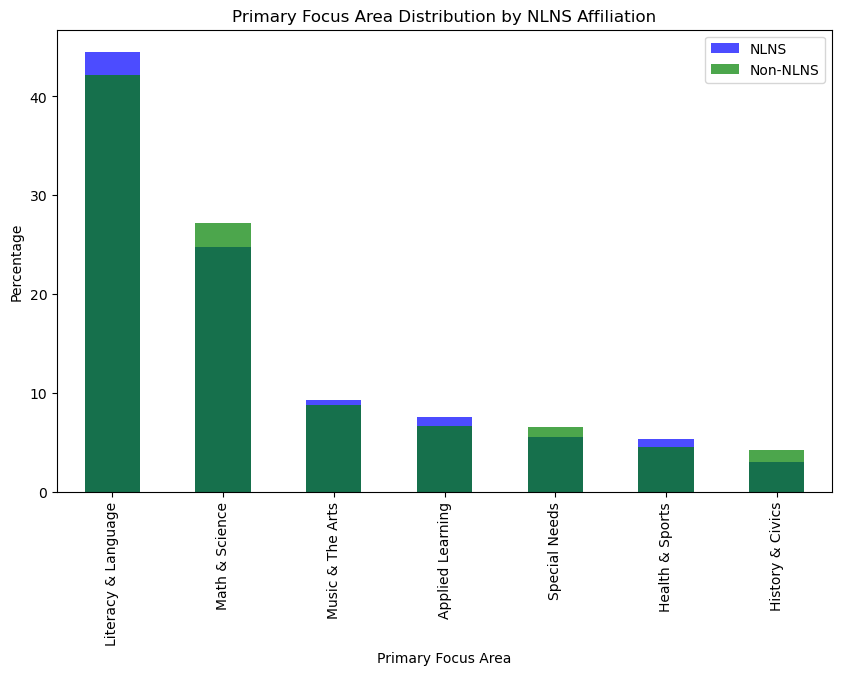

In [ ]:
# Code adjusted based on suggestions from ChatGPT, OpenAI, 2023
# Focus area distribution
plt.figure(figsize=(10, 6))
nlns_focus_area_distribution.plot(kind='bar', color='blue', alpha=0.7, label='NLNS')
non_nlns_focus_area_distribution.plot(kind='bar', color='green', alpha=0.7, label='Non-NLNS')
plt.title('Primary Focus Area Distribution by NLNS Affiliation')
plt.xlabel('Primary Focus Area')
plt.ylabel('Percentage')
plt.legend()
plt.savefig(f"Primary focus area Distribution by nlns affiliation.png")
plt.show()

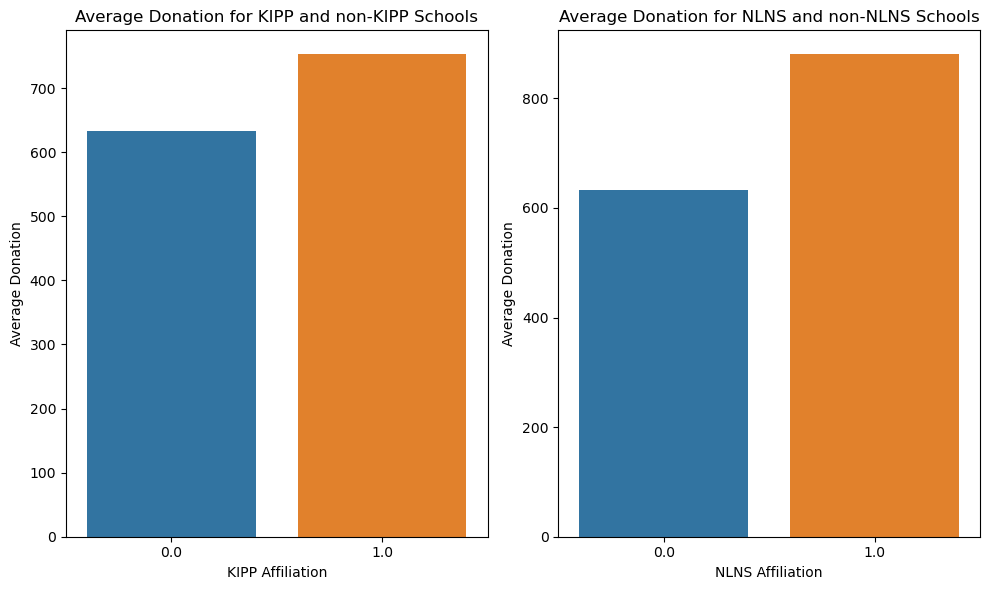

In [ ]:
# Code adjusted based on suggestions from ChatGPT, OpenAI, 2023
kipp_avg_donation = combined_df.groupby('kipp')['total_donations'].mean()
nlns_avg_donation = combined_df.groupby('nlns')['total_donations'].mean()
plt.figure(figsize=(10, 6))

# Average donation for KIPP and non-KIPP schools
plt.subplot(1, 2, 1)
sns.barplot(x=kipp_avg_donation.index, y=kipp_avg_donation.values)
plt.title('Average Donation for KIPP and non-KIPP Schools')
plt.xlabel('KIPP Affiliation')
plt.ylabel('Average Donation')

# Average donation for NLNS and non-NLNS schools
plt.subplot(1, 2, 2)
sns.barplot(x=nlns_avg_donation.index, y=nlns_avg_donation.values)
plt.title('Average Donation for NLNS and non-NLNS Schools')
plt.xlabel('NLNS Affiliation')
plt.ylabel('Average Donation')
plt.savefig(f"Average donation for schools.png")
plt.tight_layout()
plt.show()


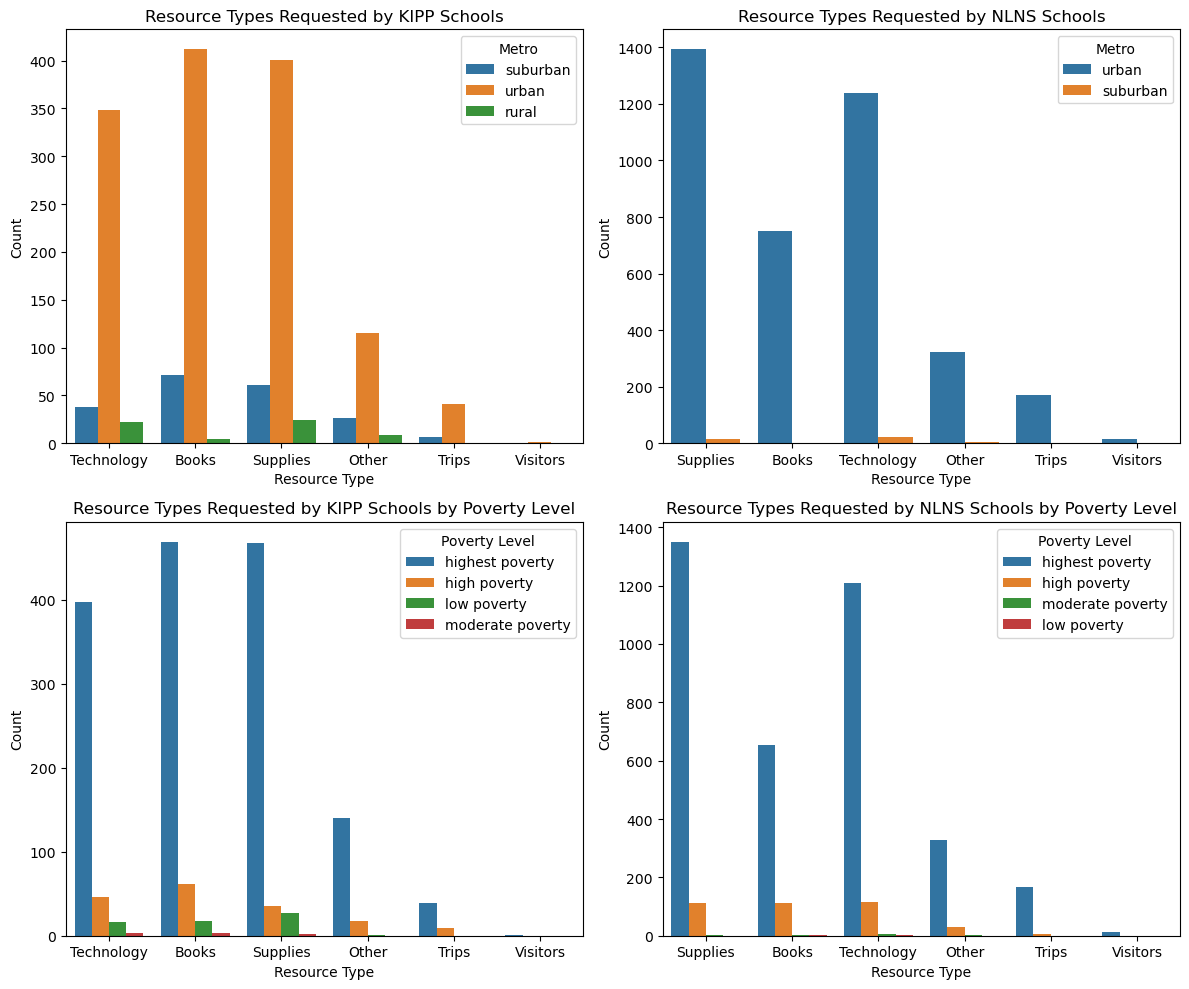

In [ ]:
# Code adjusted based on suggestions from ChatGPT, OpenAI, 2023
# Filter KIPP schools
kipp_schools = combined_df[combined_df['kipp'] == 1]

# Filter NLNS schools
nlns_schools = combined_df[combined_df['nlns'] == 1]

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Plot for KIPP schools
sns.countplot(x='resource_type', hue='metro', data=kipp_schools, ax=axes[0, 0])
axes[0, 0].set_title('Resource Types Requested by KIPP Schools')
axes[0, 0].set_xlabel('Resource Type')
axes[0, 0].set_ylabel('Count')
axes[0, 0].legend(title='Metro')

# Plot for NLNS schools
sns.countplot(x='resource_type', hue='metro', data=nlns_schools, ax=axes[0, 1])
axes[0, 1].set_title('Resource Types Requested by NLNS Schools')
axes[0, 1].set_xlabel('Resource Type')
axes[0, 1].set_ylabel('Count')
axes[0, 1].legend(title='Metro')

# Plot for KIPP schools by poverty level
sns.countplot(x='resource_type', hue='poverty_level', data=kipp_schools, ax=axes[1, 0])
axes[1, 0].set_title('Resource Types Requested by KIPP Schools by Poverty Level')
axes[1, 0].set_xlabel('Resource Type')
axes[1, 0].set_ylabel('Count')
axes[1, 0].legend(title='Poverty Level')

# Plot for NLNS schools by poverty level
sns.countplot(x='resource_type', hue='poverty_level', data=nlns_schools, ax=axes[1, 1])
axes[1, 1].set_title('Resource Types Requested by NLNS Schools by Poverty Level')
axes[1, 1].set_xlabel('Resource Type')
axes[1, 1].set_ylabel('Count')
axes[1, 1].legend(title='Poverty Level')
plt.savefig(f"Resource types requested.png")
plt.tight_layout()
plt.show()

________________________________________________________________________________________________

## Jai's Data Analysis - Analysis of donations by time and funding status by resource type

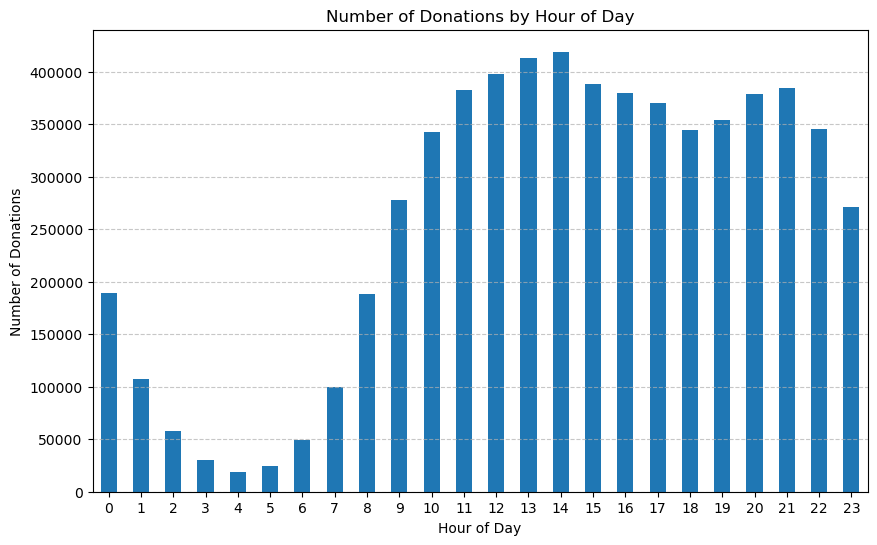

In [ ]:
# Code adjusted based on suggestions from ChatGPT, OpenAI, 2023
# Analyzing Donation Timestamp
combined_df['donation_timestamp'] = pd.to_datetime(combined_df['donation_timestamp'])
combined_df['hour_of_day'] = combined_df['donation_timestamp'].dt.hour
hourly_donations = combined_df['hour_of_day'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
hourly_donations.plot(kind='bar')
plt.title('Number of Donations by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Donations')
plt.xticks(range(0, 24), rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('Number of Donations by Hour of Day.png', dpi=300, bbox_inches='tight')
plt.show()

/var/folders/m2/f1xv81ts7w73wj1z1dys855h0000gn/T/ipykernel_20846/320069085.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.right_ax.set_yticklabels(['${:,.0f}'.format(y) for y in ax.right_ax.get_yticks()])


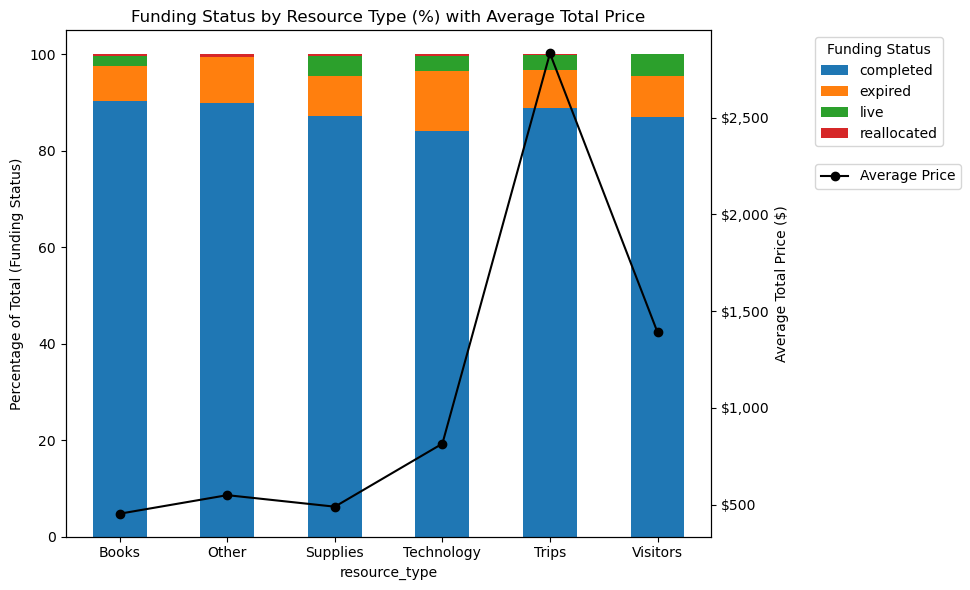

In [ ]:
# Code adjusted based on suggestions from ChatGPT, OpenAI, 2023
# Resource Type Correlation with Funding Success
# Creating a crosstab (ct) of resource type and funding status
ct = pd.crosstab(combined_df['resource_type'], combined_df['funding_status'])
ct_pct = ct.div(ct.sum(axis=1), axis=0) * 100
avg_price = combined_df.groupby('resource_type')['total_price_excluding_optional_support'].mean()
# Plotting the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
ct_pct.plot(kind='bar', stacked=True, ax=ax)
plt.title('Funding Status by Resource Type (%) with Average Total Price')
ax.set_xlabel('Resource Type')
plt.ylabel('Percentage of Total (Funding Status)')
plt.xticks(rotation=0)
avg_price.plot(kind='line', marker='o', secondary_y=True, color='k', ax=ax)
ax.right_ax.set_ylabel('Average Total Price ($)')
ax.right_ax.set_yticklabels(['${:,.0f}'.format(y) for y in ax.right_ax.get_yticks()])
ax.legend(title='Funding Status', loc='upper left', bbox_to_anchor=(1.15, 1))
ax.right_ax.legend(['Average Price'], loc='upper left', bbox_to_anchor=(1.15, 0.75))
plt.tight_layout()
plt.savefig('Funding Status by Resource Type and Price.png', dpi=300, bbox_inches='tight')
plt.show()

________________________________________________________________________________________________

## Beginning of Linear Regression Analysis (incomplete but future work)

In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
donation[["donation_to_project", "donation_optional_support", "donation_total"]].describe()

,donation_to_project,donation_optional_support,donation_total
count,6211956.00,6211956.00,6211956.00
mean,69.73,10.94,80.66
std,247.89,37.82,280.89
min,-12.75,-2.25,-15.00
25%,10.00,1.50,10.00
50%,21.25,3.75,25.00
75%,53.76,7.50,61.20
max,147204.00,21996.00,169200.00


<Axes: xlabel='payment_method', ylabel='count'>

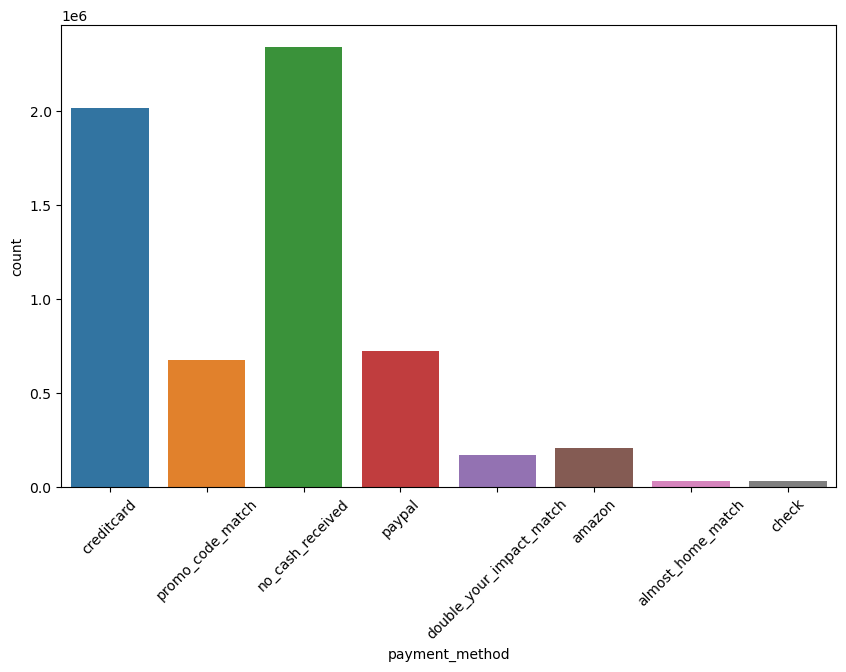

In [ ]:
plt.figure(figsize=(10, 6))
plt.xticks(rotation=45)
sns.countplot(data=donation, x='payment_method')

<Axes: xlabel='payment_method', ylabel='donation_to_project'>

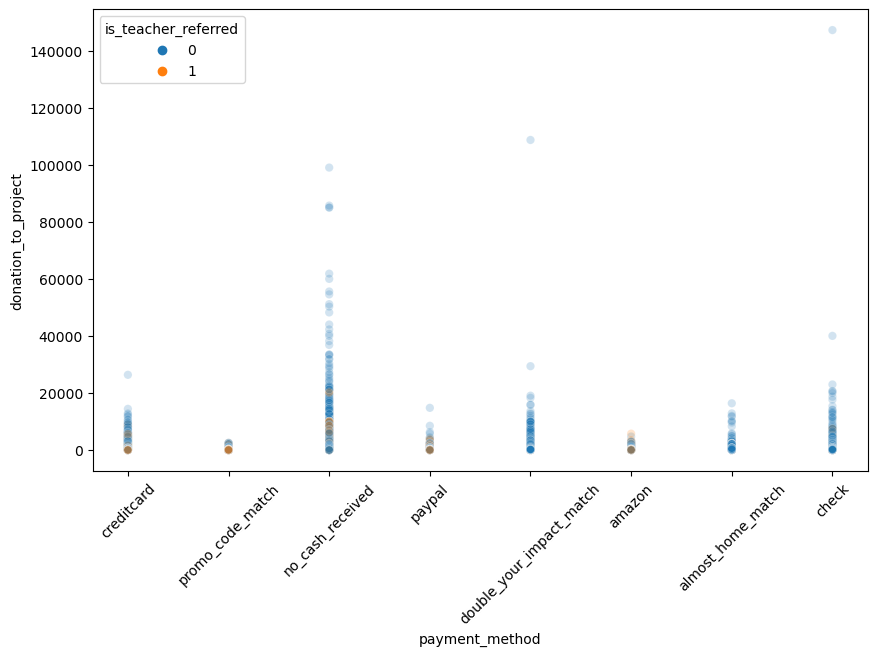

In [ ]:
plt.figure(figsize=(10, 6))
plt.xticks(rotation=45)
sns.scatterplot(data=donation, x='payment_method', y='donation_to_project', hue='is_teacher_referred', alpha=0.2)

In [ ]:
donation_df = donation.drop(columns=['projectid', 'donoracctid', 'donation_timestamp', 'givingpageid'])

In [ ]:
donation_df = pd.get_dummies(donation_df, columns=["giving_page_type", "payment_method"])

In [ ]:
donation_df.head()

,donationid,donation_to_project,donation_optional_support,donation_total,donation_included_optional_support,payment_included_acct_credit,payment_included_campaign_gift_card,payment_included_web_purchased_gift_card,payment_was_promo_matched,is_teacher_referred,...,giving_page_type_campaign,giving_page_type_teacher,payment_method_almost_home_match,payment_method_amazon,payment_method_check,payment_method_creditcard,payment_method_double_your_impact_match,payment_method_no_cash_received,payment_method_paypal,payment_method_promo_code_match
0,1,8.50,1.50,10.00,1,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,False
1,2,63.75,11.25,75.00,1,0,0,0,1,0,...,False,False,False,False,False,True,False,False,False,False
2,3,21.25,3.75,25.00,1,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,True
3,4,20.50,4.50,25.00,1,1,0,0,0,0,...,False,False,False,False,False,False,False,True,False,False
4,5,1817.36,320.71,2138.07,1,1,0,0,0,0,...,True,False,False,False,False,False,False,True,False,False


In [ ]:
data_train, data_test = train_test_split(donation_df)

In [ ]:
X_train, X_test = data_train.drop(columns=["donation_total", "donation_to_project", "donation_optional_support"]), data_test.drop(columns=["donation_total", "donation_to_project", "donation_optional_support"])

y_train, y_test = data_train["donation_total"], data_test["donation_total"]

In [ ]:
clf = LinearRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
len(data_test['donationid'])

1552989

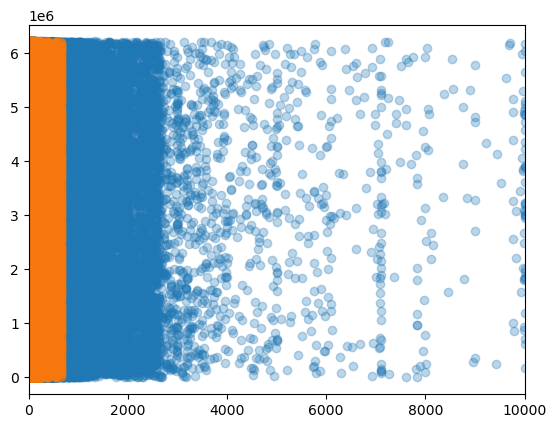

In [ ]:
plt.scatter(data_test['donation_total'], data_test['donationid'], alpha=0.3)
plt.scatter(y_pred, data_test['donationid'], alpha=0.1)
plt.xlim(0, 10000)  # Set the limit for x-axis
plt.show()